# C1 – Week 1: Content-Based Image Retrieval

**Team 1:**
- GARCÍA TAPIA, Adrián  
- SABATER OLIVERAS, Maiol  
- VILAPLANA PELEGRÍ, Gerard  
- GARCIA TORNÉ, Júlia  

---


In [17]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

import pickle

try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False


In [18]:
# Base paths
DATASET_DIR = "./datasets/"
DESCRIPTORS_DIR = "./descriptors/"
RESULTS_DIR = "./results/"

# Sub-paths
BBDD_PATH = os.path.join(DATASET_DIR, "BBDD/")
QSD1_PATH = os.path.join(DATASET_DIR, "qsd1_w1/")
QST1_PATH = os.path.join(DATASET_DIR, "qst1_w1/")

GT_PATH = os.path.join(QSD1_PATH, "gt_corresps.pkl")

with open(GT_PATH, 'rb') as f:
    GT = pickle.load(f)

---

### Task 1 — Create Image Descriptors
- Compute descriptors for:
  - **Museum** images (**BBDD**)
  - **Query** images (**QSD1**)


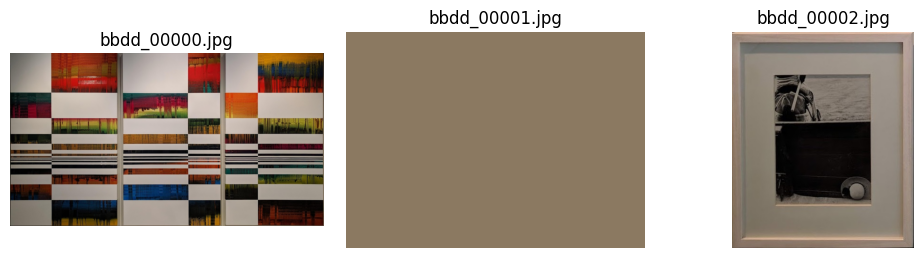

In [19]:
MUSEUM_IMAGES = os.listdir(BBDD_PATH)
MUSEUM_IMAGES = [img for img in MUSEUM_IMAGES if img.endswith('.jpg')]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for i, img_name in enumerate(MUSEUM_IMAGES[:3]):
    img = plt.imread(os.path.join(BBDD_PATH, img_name))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

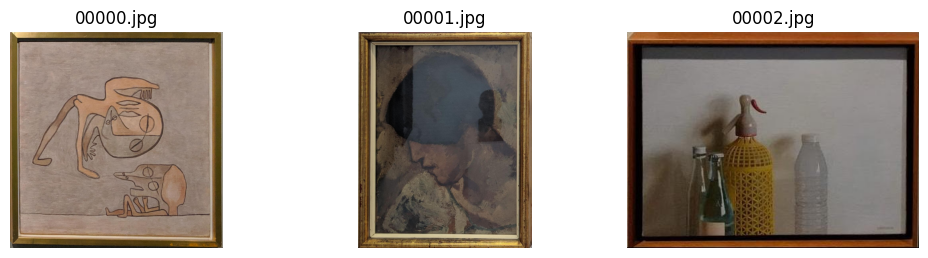

In [20]:
QUERY_IMAGES = os.listdir(QSD1_PATH)
QUERY_IMAGES = [img for img in QUERY_IMAGES if img.endswith('.jpg')]

plt.figure(figsize=(10, 5))
for i, img_name in enumerate(QUERY_IMAGES[:3]):
    img = plt.imread(os.path.join(QSD1_PATH, img_name))
    plt.subplot(2, 3, i + 4)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
print(f"#BBDD images: {len(MUSEUM_IMAGES)}")
print(f"#QSD1 images: {len(QUERY_IMAGES)}")

print(len(GT), "ground truth correspondences loaded.")

#BBDD images: 287
#QSD1 images: 30
30 ground truth correspondences loaded.


In [22]:
def read_image(path, mode=None):
    """Read image with PIL. mode can be 'L' (grayscale), 'RGB', 'HSV'."""
    img = Image.open(path)
    if mode is not None:
        img = img.convert(mode)
    else:
        img = img.convert('RGB')
    return np.array(img)

def l1_normalize(vec, eps=1e-12): 
    s = np.sum(vec) + eps
    return vec / s

def hist_1d(channel, bins, rng=(0, 256)):
    h, _ = np.histogram(channel.ravel(), bins=bins, range=rng)
    return h.astype(np.float64)

def gray_histogram(img_path, bins=32):
    arr = read_image(img_path, mode='L')
    h = hist_1d(arr, bins=bins, rng=(0,256))
    return l1_normalize(h)

def rgb_histogram(img_path, bins=32):
    arr = read_image(img_path, mode='RGB')
    r = hist_1d(arr[:,:,0], bins=bins, rng=(0,256))
    g = hist_1d(arr[:,:,1], bins=bins, rng=(0,256))
    b = hist_1d(arr[:,:,2], bins=bins, rng=(0,256))
    h = np.concatenate([r,g,b], axis=0)
    return l1_normalize(h)

def hsv_histogram(img_path, bins_h=50, bins_s=30, bins_v=30):
    # PIL's HSV ranges 0..255 for each channel
    arr = read_image(img_path, mode='HSV')
    hch = hist_1d(arr[:,:,0], bins=bins_h, rng=(0,256))
    sch = hist_1d(arr[:,:,1], bins=bins_s, rng=(0,256))
    vch = hist_1d(arr[:,:,2], bins=bins_v, rng=(0,256))
    h = np.concatenate([hch, sch, vch], axis=0)
    return l1_normalize(h)

def build_descriptors(img_folder, img_list, method='gray32'):
    """Build descriptors for a list of images given a method key."""
    if method == 'gray32':
        descs = [gray_histogram(os.path.join(img_folder, f), bins=32) for f in tqdm(img_list, desc='gray32')]
    elif method == 'rgb32x3':
        descs = [rgb_histogram(os.path.join(img_folder, f), bins=32) for f in tqdm(img_list, desc='rgb32x3')]
    elif method == 'hsv_50_30_30':
        descs = [hsv_histogram(os.path.join(img_folder, f), bins_h=50, bins_s=30, bins_v=30) for f in tqdm(img_list, desc='hsv_50_30_30')]
    else:
        raise ValueError(f"Unknown method: {method}")
    return np.vstack(descs) if len(descs)>0 else np.zeros((0,1))

In [23]:
METHODS = ['gray32', 'rgb32x3', 'hsv_50_30_30']

all_bbdd_desc = {}
all_qsd1_desc = {}

for m in METHODS:
    
    Xb = build_descriptors(BBDD_PATH, MUSEUM_IMAGES, method=m)
    Xq = build_descriptors(QSD1_PATH, QUERY_IMAGES, method=m)
    all_bbdd_desc[m] = Xb
    all_qsd1_desc[m] = Xq

    np.savez(os.path.join(DESCRIPTORS_DIR, f"bbdd_{m}.npz"), files=np.array(MUSEUM_IMAGES), X=Xb)
    np.savez(os.path.join(DESCRIPTORS_DIR, f"qsd1_{m}.npz"), files=np.array(QUERY_IMAGES),  X=Xq)

print("Saved descriptor files in:", DESCRIPTORS_DIR)

hsv_50_30_30: 100%|██████████| 30/30 [00:00<00:00, 33.03it/s]

Saved descriptor files in: ./descriptors/


In [ ]:
def prepare_stack(X_db, X_q, tag_db='BBDD', tag_q='QSD1'):
    """Stack DB and Query descriptors for joint visualization; returns X, labels, split_idx."""
    n_db = X_db.shape[0]
    n_q  = X_q.shape[0]

    X = np.vstack([X_db, X_q]) if n_db + n_q > 0 else np.zeros((0,1))

    labels = np.array([tag_db]*n_db + [tag_q]*n_q)

    # indices with label "GT" CHANGE THE LABELLS TO "GT" FOR THE INDEX IN THE GT LIST = [0,1,2,...]
    i=0
    for idx, val in enumerate(GT):

        labels[val] = str(i)
        labels[n_db + idx] = str(i)
        i+=1

    return X, labels, n_db

import matplotlib.pyplot as plt
import numpy as np

def scatter_2d(Z, labels=None, title="", figsize=(6,5), cmap_name="tab20"):
    plt.figure(figsize=figsize)
    if labels is None:
        plt.scatter(Z[:,0], Z[:,1], s=25)
    else:
        uniq = list(dict.fromkeys(labels.tolist()))
        cmap = plt.cm.get_cmap(cmap_name, len(uniq))  
        shapes = ['o', 's', '^', 'P', '*', 'X', 'D'] 

        for i, u in enumerate(uniq):
            idx = (labels == u)
            plt.scatter(
                Z[idx,0], Z[idx,1],
                label=u,
                s=25,
                marker=shapes[i % len(shapes)],
                color=cmap(i) 
            )
        #plt.legend(loc='lower left', fontsize='small', markerscale=2)

    plt.title(title)
    plt.xlabel("dim 1"); plt.ylabel("dim 2")
    plt.show()


In [25]:
for m in METHODS:

    X_db = all_bbdd_desc[m]
    X_q  = all_qsd1_desc[m]

    print(X_db.shape)
    print(X_q.shape)
    print(len(GT))

    break


(287, 32)
(30, 32)
30


C:\Users\User\AppData\Local\Temp\ipykernel_35128\1108275222.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(uniq))


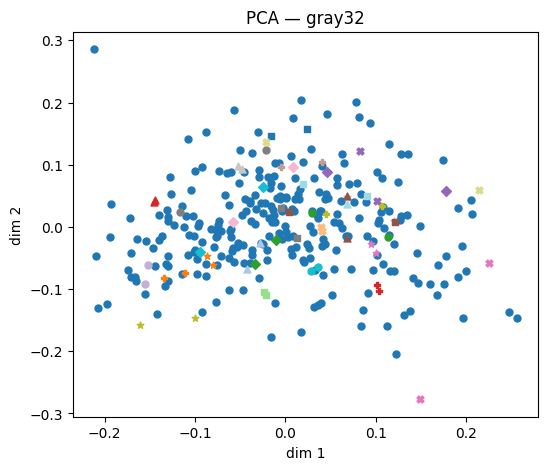

C:\Users\User\AppData\Local\Temp\ipykernel_35128\1108275222.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(uniq))


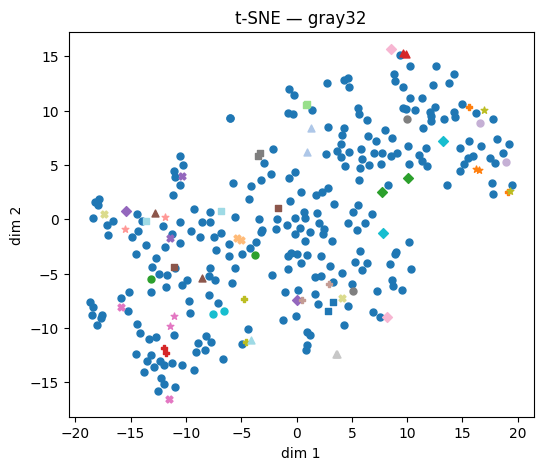

C:\Users\User\AppData\Local\Temp\ipykernel_35128\1108275222.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(uniq))


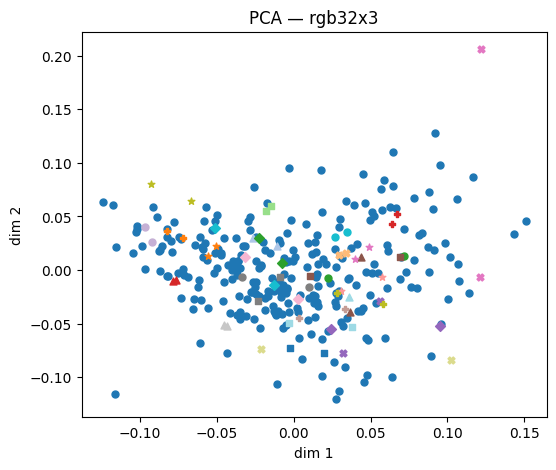

C:\Users\User\AppData\Local\Temp\ipykernel_35128\1108275222.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(uniq))


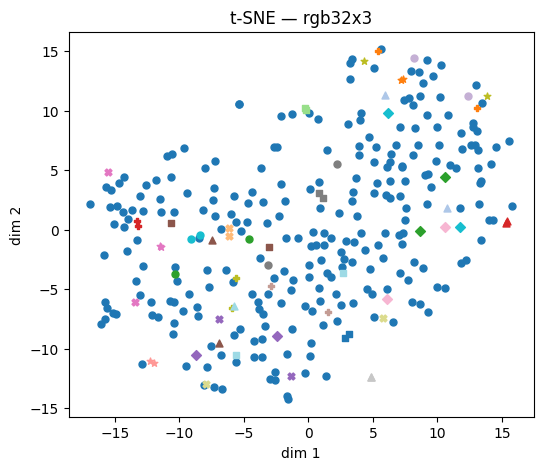

C:\Users\User\AppData\Local\Temp\ipykernel_35128\1108275222.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(uniq))


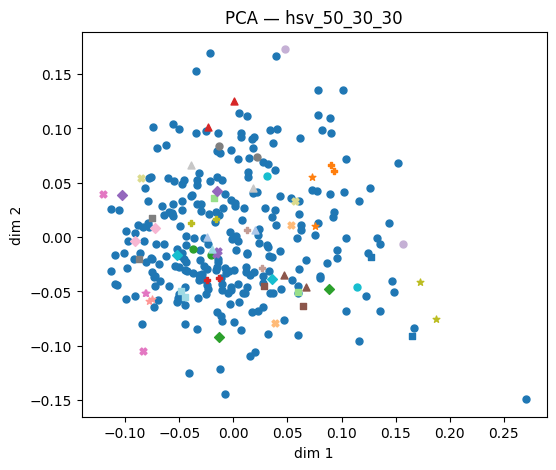

C:\Users\User\AppData\Local\Temp\ipykernel_35128\1108275222.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(uniq))


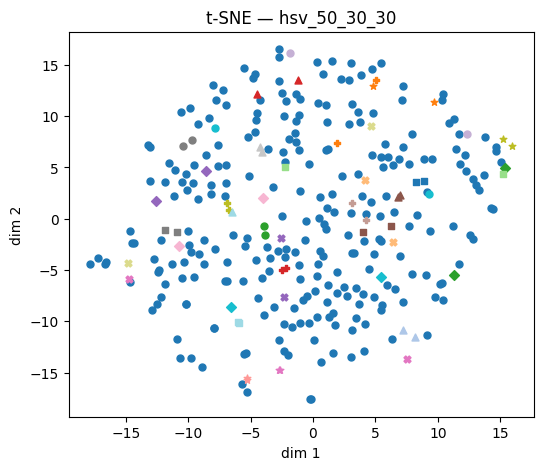

In [60]:
for m in METHODS:

    X_db = all_bbdd_desc[m]
    X_q  = all_qsd1_desc[m]

    X, tag, _ = prepare_stack(X_db, X_q)

    if X.shape[0] == 0:
        print(f"[WARN] No data for method {m}. Skipping.")
        continue

    # L1-normalize
    X_std = X / (X.sum(axis=1, keepdims=True) + 1e-12)

    Z_pca = PCA(n_components=2, random_state=0).fit_transform(X_std)
    scatter_2d(Z_pca, labels=tag, title=f"PCA — {m}")

    Z_tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=0).fit_transform(X_std)
    scatter_2d(Z_tsne, labels=tag, title=f"t-SNE — {m}")

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)

def scatter_3d(Z, labels=None, title="", figsize=(7,6), elev=20, azim=35):
    """
    3D scatter plot.
    Z: array of shape (n_samples, 3)
    labels: optional array-like of shape (n_samples,) with string labels
    elev, azim: initial view angles (degrees)
    """
    Z = np.asarray(Z)
    if Z.ndim != 2 or Z.shape[1] < 3:
        raise ValueError("Z must be of shape (n_samples, 3).")

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    if labels is None:
        ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], s=20, depthshade=True)
    else:
        labels = np.asarray(labels)
        # preserve first-seen order of labels (like your 2D function)
        uniq = list(dict.fromkeys(labels.tolist()))
        for u in uniq:
            idx = (labels == u)
            ax.scatter(Z[idx, 0], Z[idx, 1], Z[idx, 2], label=u, s=20, depthshade=True)
        #ax.legend(loc="best")

    ax.set_title(title)
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")
    ax.set_zlabel("dim 3")
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.show()

c:\Users\User\anaconda3\envs\ai_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


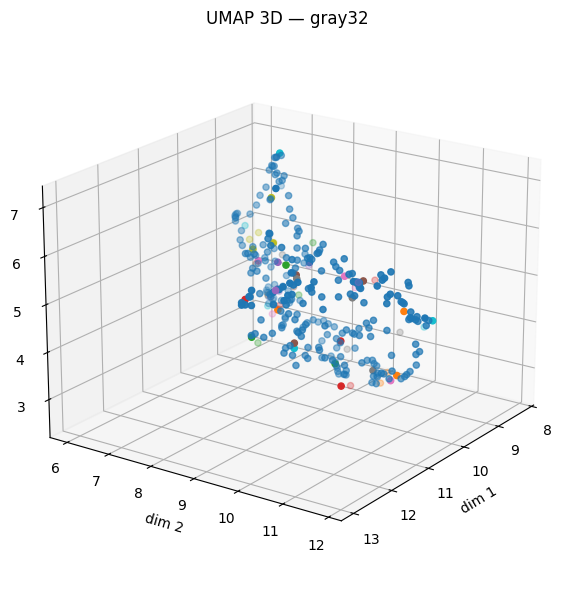

c:\Users\User\anaconda3\envs\ai_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


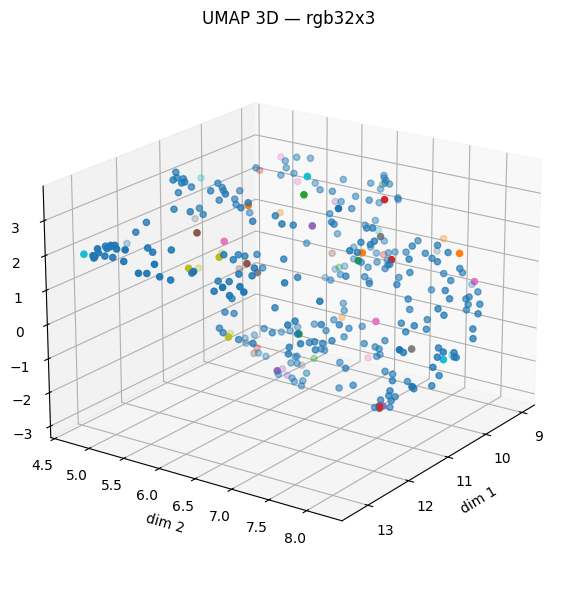

c:\Users\User\anaconda3\envs\ai_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


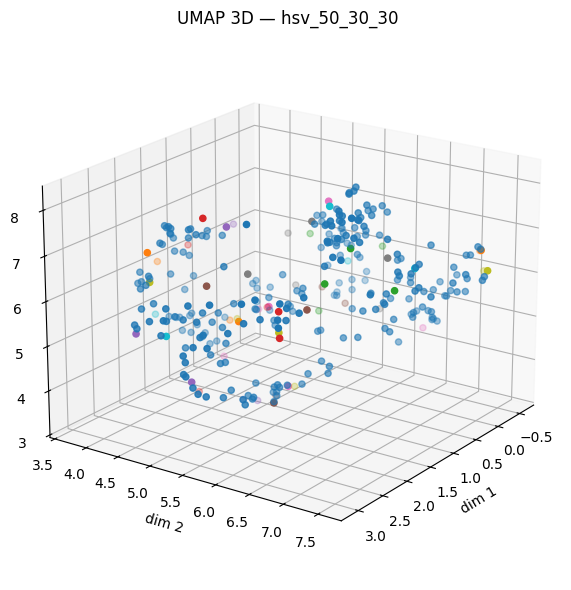

In [54]:
if HAS_UMAP:
    for m in METHODS:
        X_db = all_bbdd_desc[m]
        X_q  = all_qsd1_desc[m]
        X, tag, _ = prepare_stack(X_db, X_q)

        if X.shape[0] == 0:
            print(f"[WARN] No data for method {m}. Skipping UMAP.")
            continue

        # row-normalize (safe for zeros)
        X_std = X / (X.sum(axis=1, keepdims=True) + 1e-12)

        try:
            reducer = umap.UMAP(n_components=3, random_state=0)
            Z_umap_3d = reducer.fit_transform(X_std)
            scatter_3d(Z_umap_3d, labels=tag, title=f"UMAP 3D — {m}")
        except Exception as e:
            print(f"[WARN] UMAP 3D failed for {m}: {e}")
else:
    print("UMAP not installed — skipping UMAP plots. To enable: pip install umap-learn")


---
### Task 2 — Similarity Measures
- Implement / compute similarity metrics to compare image descriptors.

In [29]:
# Code

---
### Task 3 — Retrieval System
- For each query image, **retrieve the Top-K** most similar images from **BBDD**, **sorted by score**.

In [30]:
# Code

---
### Task 4 — Blind Challenge Predictions
- Generate predictions for **`QST1`** (blind challenge).

In [31]:
# Code

In [5]:
import pandas as pd

csv_file = "TESTS_v2.csv"
df = pd.read_csv(csv_file)

top_row = df.loc[df['MAP@1'].idxmax()]
print("Top row by map@1:")
print(top_row)

top_row = df.loc[df['MAP@5'].idxmax()]
print("Top row by map@5:")
print(top_row)

Top row by map@1:
Histogram_Method              lab_40x3
Preprocess                       clahe
Similarity_Method    hist_intersection
MAP@1                           0.6667
MAP@5                           0.7139
Name: 982, dtype: object
Top row by map@5:
Histogram_Method     lab_128x3
Preprocess               clahe
Similarity_Method     canberra
MAP@1                   0.6333
MAP@5                   0.7278
Name: 1470, dtype: object
